![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Change current working directory to project folder

In [2]:
import os
os.chdir('/content/drive/MyDrive/PINS')

# Import Packages



In [3]:
!pip install h5py
import h5py


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import re, random

from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.models import Sequential, Model
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

random_state = 2020

import warnings
warnings.filterwarnings('ignore')




### Extract the zip file
- Extract Aligned Face Dataset from Pinterest.zip

as I've unzipped the dataset first & then it was uploaded, hence skipping this step

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id


In [5]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

# metadata = load_metadata('images')
metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

### Define function to load image
- Define a function to load image from the metadata

In [6]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image
- Load one image using the function "load_image"

In [7]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

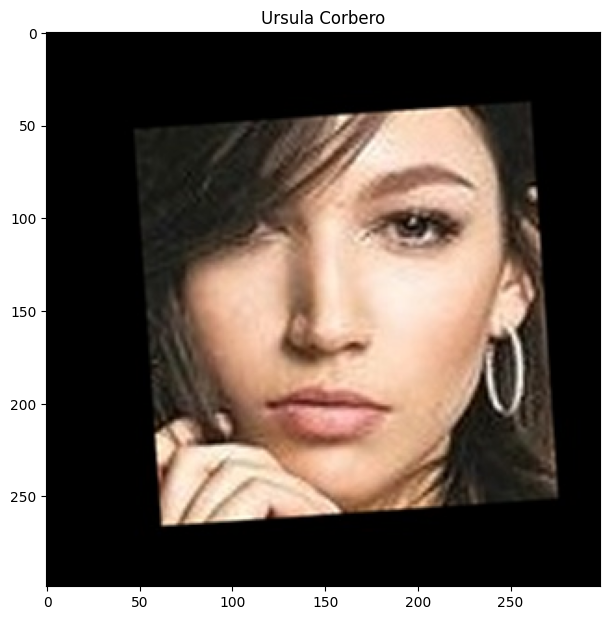

In [8]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title)
_ = plt.imshow(img)

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [9]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [10]:
model = vgg_face()
model.load_weights('/content/drive/MyDrive/vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 226, 226, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

### Get vgg_face_descriptor

In [11]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [12]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
(2622,)


### Generate embeddings for all images
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [13]:
from tqdm import tqdm
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))

for i, meta in enumerate(metadata):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (244, 244))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 714ms/step


### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [14]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

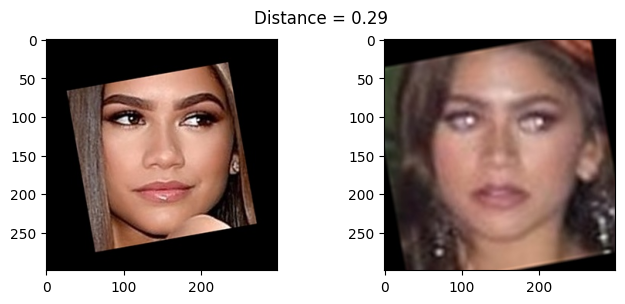

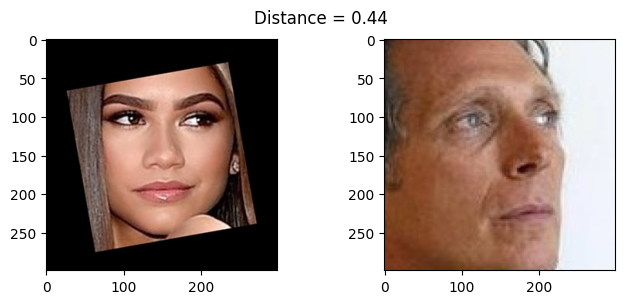

In [15]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(2, 3)
show_pair(2, 180)

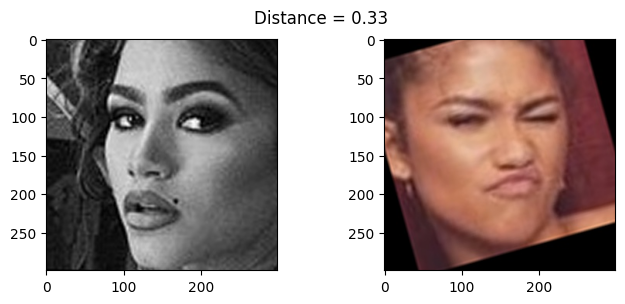

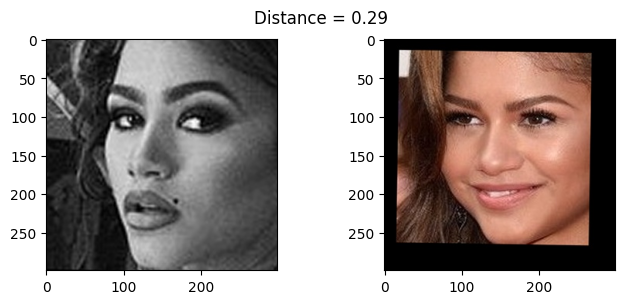

In [16]:
# 30, 31 and 30, 100

show_pair(30, 31)
show_pair(30, 100)

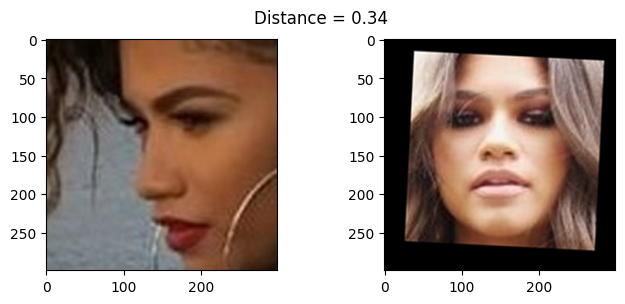

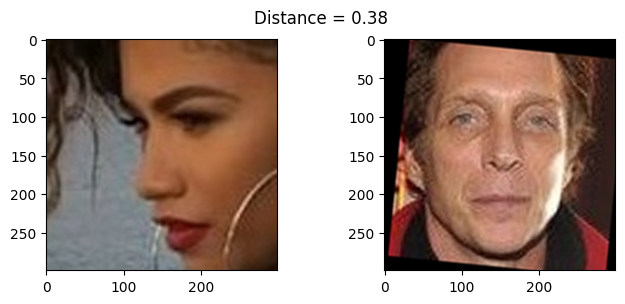

In [17]:
# 70, 72 and 70, 115

show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [18]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]
# another half as test examples of 10 identities

#### Add your code here ####

y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(5434, 2622)
(680, 2622)
(5434,)
(680,)


### Encode the Labels
- Encode the targets
- Use LabelEncoder

In [19]:
from sklearn.preprocessing import LabelEncoder

en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

### Standardize the feature values
- Scale the features using StandardScaler

In [20]:
# Standarize features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Reduce dimensions using PCA (5 marks)
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [21]:
from sklearn.decomposition import PCA

cov_matrix = np.cov(X_train_sc.T)
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

tot = sum(eig_vals)
var_exp = [(i/tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print(cum_var_exp)

[ 13.86054871  19.52397144  23.69636816 ...  99.99999989  99.99999999
 100.        ]


In [22]:
thres = 95
res = list(filter(lambda i : i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))


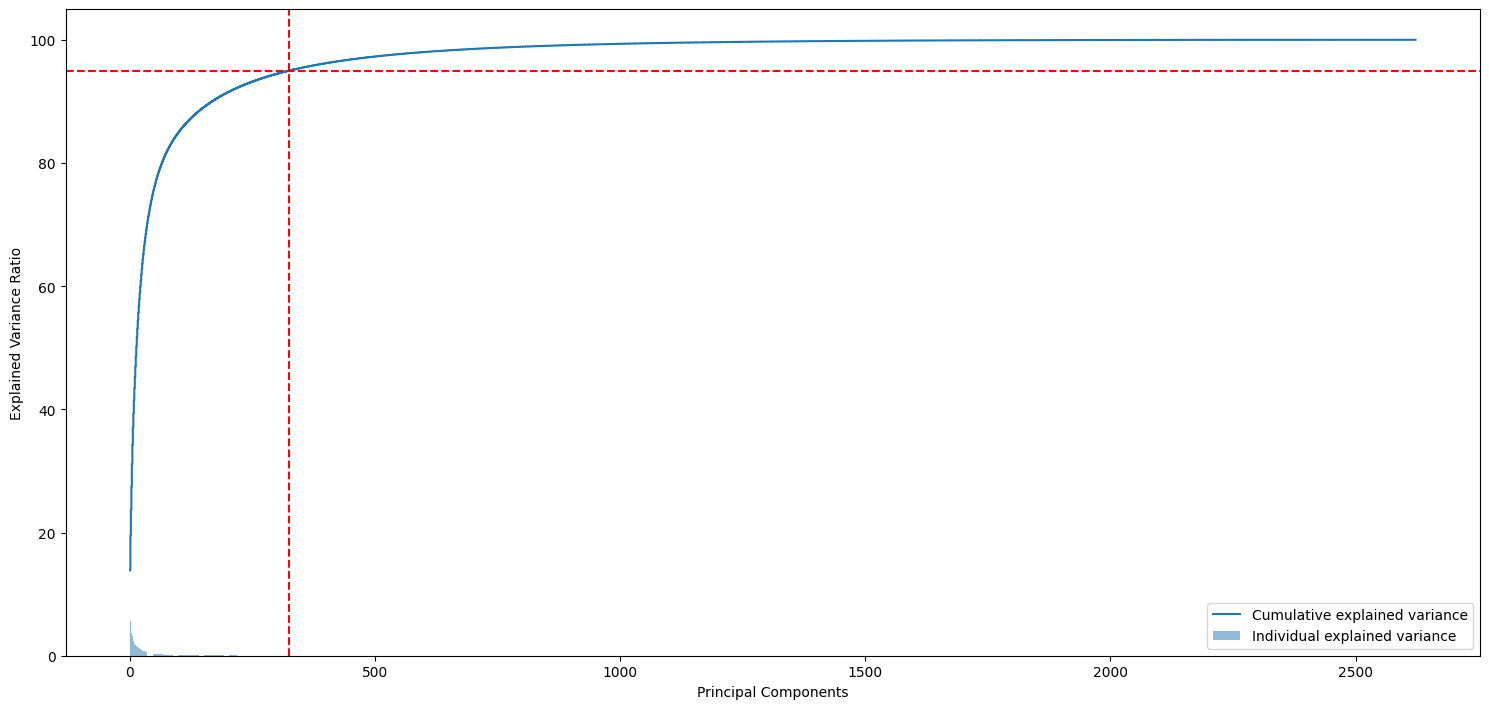

In [23]:
# lets do some plotting

plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [24]:
pca = PCA(n_components = 128, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(5434, 128)

(680, 128)

### Build a Classifier (5 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [25]:
from sklearn.svm import SVC

svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.977


In [26]:
y_pred = svc_pca.predict(X_test_pca)

print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.969


In [27]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                       precision    recall  f1-score   support

           Emma Stone       1.00      0.93      0.96        14
     Emma Watson Face       1.00      1.00      1.00         5
          Henry Cavil       1.00      1.00      1.00        15
         Jason Isaacs       1.00      1.00      1.00        13
          Jason Momoa       1.00      1.00      1.00        10
           Jeff Bezos       1.00      1.00      1.00        12
        Jeremy Renner       0.83      0.71      0.77         7
      Jesse Eisenberg       1.00      1.00      1.00        11
          Jim Parsons       1.00      1.00      1.00        12
         Jon Bernthal       1.00      1.00      1.00        13
          Josh Radnor       1.00      1.00      1.00        10
       Kiernan Shipka       1.00      1.00      1.00        16
        Kit Harington       1.00      0.92      0.96        13
 Kristen Stewart Face       1.00      0.83      0.91         6
       Krysten Ritter       1.

### Test results (2 marks)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

In [28]:
def sample_img_plot(sample_idx):
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  sample_img = (sample_img/255.).astype(np.float32)
  sample_img = cv2.resize(sample_img, (224, 224))
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

1/1 [==============================] - 1s 663ms/step


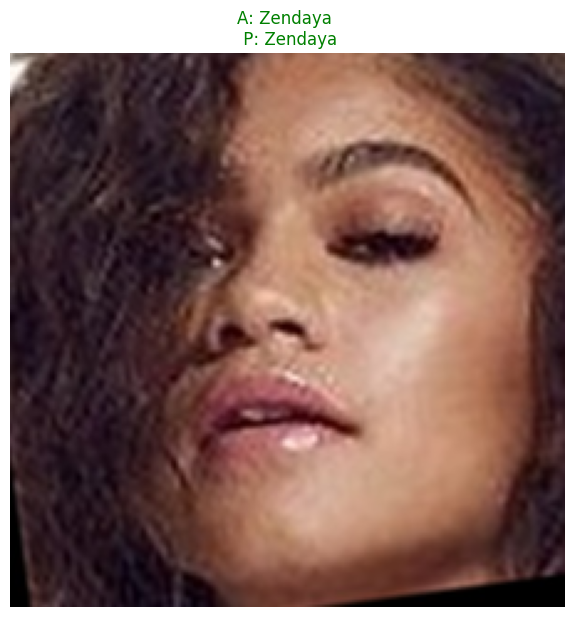

In [29]:
# Plot for 10th image in test data
sample_img, actual_name, pred_name = sample_img_plot(10)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

image belongs to ZENDYA folder